In [2]:
%load_ext autoreload
%autoreload 2

from datasets import DataCocoFeat
from models import RNNCaption
from optimers import OptimerAdam, OptimerSGD
from utils import check_gradient, show_training_info, show_training_infos
import numpy as np

# Data loader

In [3]:
# load data
dataloader = DataCocoFeat('./datasets/coco_captioning/', pca_features=True)
dataloader.show_info()

Training data shape:  (400135, 512)
Training labels shape:  (400135, 17)
Validation data shape:  (195954, 512)
Validation labels shape:  (195954, 17)
Number of training images:  82783
Number of validation images:  40504
Number of words:  1004


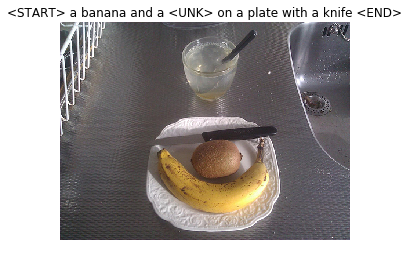

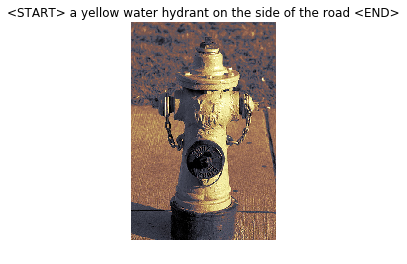

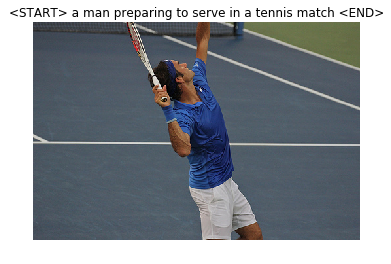

In [3]:
# show some examples
for indx in np.random.choice(dataloader.x_train.shape[0], 3, replace=False):
    img, caption = dataloader.show_by_index(indx)

# Sanity check

### Init loss

In [4]:
def get_init_model(hyperparams):
    return RNNCaption(512, None, hyperparams=hyperparams, seed=100)

# init model
model = get_init_model({'word_to_idx': dataloader.data['word_to_idx'],
                        'reg': 0., 'num_hidden': 64, 'num_vector': 64, 'init_scale': None})

# init loss -log(1./1004)=6.91
loss = model.backward(dataloader.x_train[0: 100, :], dataloader.y_train[0: 100])
print('Sanity check result:')
print('Init loss is', loss)

Sanity check result:
Init loss is 6.977001923015437


### Gradient check

In [6]:
# gradient check
for i in range(3):
    print('\nGradient check result - ', i + 1, ':')
    check_gradient(model, dataloader.x_train[0: 100, :], dataloader.y_train[0: 100])


Gradient check result -  1 :
Layer | Key | Numerical gradient | Calculated gradient | Relative error
<class 'models.layers.layers.Linear'> W 0.001085893464036758 0.0010858934281146079 3.308073195396626e-08
<class 'models.layers.layers.Linear'> b -0.001999452248213629 -0.001999452672986061 2.1244437686935603e-07
<class 'models.layers.rnn_layers.WordEmbedding'> W_embed 0.0 0.0 nan
<class 'models.layers.rnn_layers.RNN'> Wx -5.918243672908829e-05 -5.918242452440749e-05 2.0622135092560354e-07
<class 'models.layers.rnn_layers.RNN'> Wh 0.0019181238375409746 0.00191812452997511 3.609954669690566e-07
<class 'models.layers.rnn_layers.RNN'> b 0.025990812746456978 0.02599081511837379 9.125981273359756e-08
<class 'models.layers.rnn_layers.LinearForRNN'> W 2.113131891690045e-05 2.1131328929763118e-05 4.738398172912583e-07
<class 'models.layers.rnn_layers.LinearForRNN'> b 0.0011231454877247415 0.001123145658005971 1.5161100533354091e-07

Gradient check result -  2 :
Layer | Key | Numerical gradient 

### Overfit small dataset

In [48]:
# load small dataset
smallloader = DataCocoFeat('./datasets/coco_captioning/', pca_features=True,
                           num_train=50, num_val=50)

# init model
model = get_init_model({'word_to_idx': dataloader.data['word_to_idx'],
                        'reg': 0., 'num_hidden': 1024, 'num_vector': 512})

# train model
optimer = OptimerAdam({'learn_rate': 1e-1, 'num_iters': 200,'batch_size': 25}, 
                      print_every=20, check_val_acc=False, check_train_acc=False)

optimer.train(model, smallloader)

# save model
model.save('./saves/RNNCaption/model_small.pkl')

0 / 200 loss is 6.91174719661682
20 / 200 loss is 15.039229556801208
40 / 200 loss is 11.172051246522106
60 / 200 loss is 5.258901683878306
80 / 200 loss is 2.0041188287661513
100 / 200 loss is 0.558973533879795
120 / 200 loss is 0.26010550743596994
140 / 200 loss is 0.06765027794636315
160 / 200 loss is 0.1696678290646034
180 / 200 loss is 0.14034728652857792


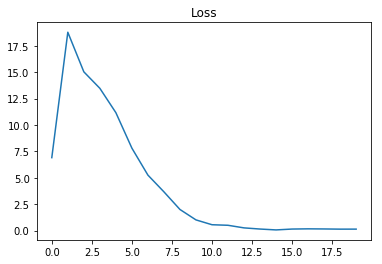

In [49]:
# plot loss curve
show_training_info(optimer)

In [5]:
def test_model(model, dataloader, idx_train, idx_val):
    caps_train = model.predict(dataloader.x_train[idx_train])
    caps_val = model.predict(dataloader.x_val[idx_val])

    # the predicted captions
    for i in range(len(caps_train)):
        print('Predicted training data:', dataloader.decode_captions(caps_train[i]))
        dataloader.show_by_index(idx_train[i], data_type='train')

    for i in range(len(caps_val)):
        print('Predicted validation data:', dataloader.decode_captions(caps_val[i]))
        dataloader.show_by_index(idx_val[i], data_type='test')

Predicted training data: <START> a blue and white bathroom with <UNK> <UNK> wall <UNK> <END>


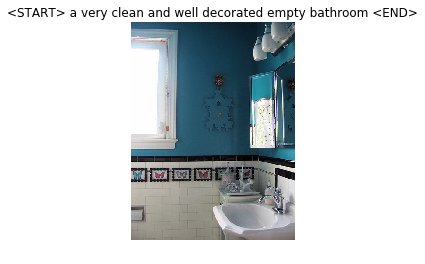

Predicted training data: <START> a wide <UNK> view of the kitchen work area <END>


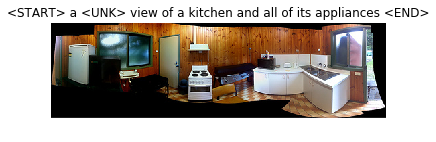

Predicted training data: <START> a <UNK> stop sign and a red <UNK> on the road <END>


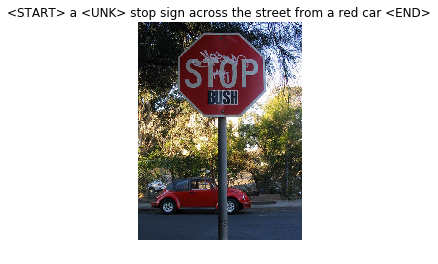

Predicted validation data: <START> bathroom purple bicycles and black appliances <END>


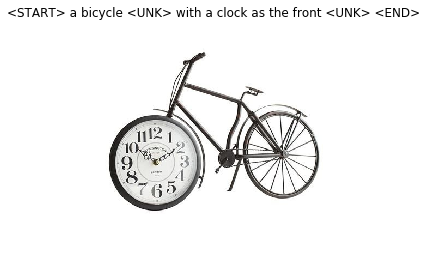

Predicted validation data: <START> a surfer a woman and a child walk on the beach <END>


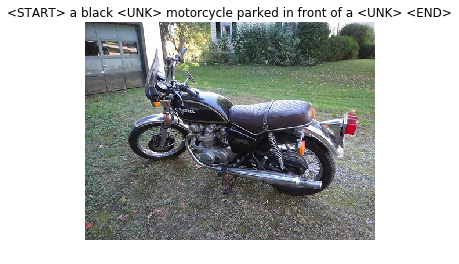

Predicted validation data: <START> car sign across a at a kitchen counter in a room <UNK> by <UNK> <END>


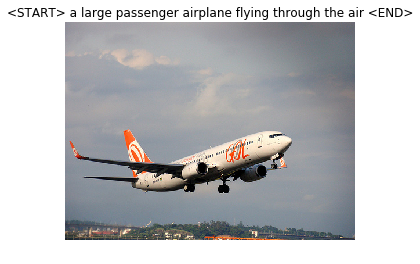

In [50]:
# load model
model = RNNCaption.load('./saves/RNNCaption/model_small.pkl')

# test model
test_model(model, smallloader, [0, 1, 4], [0, 1, 4])

# Train RNN-Caption model

### Compare different optimers

In [29]:
# Adam optimer
optimer1 = OptimerAdam({'learn_rate': 2e-3, 'learn_rate_decay': 1.0, 'num_iters': 500,'batch_size': 200}, 
                      print_every=100, check_val_acc=False, check_train_acc=False)

# train models
model = get_init_model({'word_to_idx': dataloader.data['word_to_idx'],
                        'reg': 0.01, 'num_hidden': 512, 'num_vector': 256})
optimer1.train(model, dataloader)

0 / 500 loss is 6.911785952357161
100 / 500 loss is 4.084998675954769
200 / 500 loss is 3.9524072109205997
300 / 500 loss is 3.6890049460321133
400 / 500 loss is 3.5881345177421533


In [33]:
# SDG optimer
optimer2 = OptimerSGD({'learn_rate': 5e-1, 'learn_rate_decay': 1.0, 'num_iters': 500,'batch_size': 200}, 
                      print_every=100, check_val_acc=False, check_train_acc=False)

# train models
model = get_init_model({'word_to_idx': dataloader.data['word_to_idx'],
                        'reg': 0.01, 'num_hidden': 512, 'num_vector': 256})
optimer2.train(model, dataloader)

0 / 500 loss is 6.911785952357161
100 / 500 loss is 5.113051175384881
200 / 500 loss is 4.933700739859999
300 / 500 loss is 4.9279684318301396
400 / 500 loss is 4.742802752607746


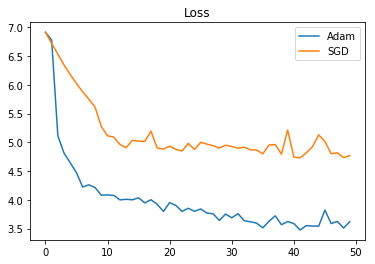

In [35]:
show_training_infos([optimer1, optimer2], 
                    legends=['Adam', 'SGD'], 
                    contains=['loss'])

### Train Model

In [17]:
# init model
if False:
    model = get_init_model({'word_to_idx': dataloader.data['word_to_idx'],
                            'reg': 0.01, 'num_hidden': 1024, 'num_vector': 512})
else:
    model = RNNCaption.load('./saves/RNNCaption/model.pkl')

# train model 'learn_rate': 2e-3
optimer = OptimerAdam({'learn_rate': 1e-3, 'learn_rate_decay': 1.0, 'num_iters': 1000,'batch_size': 256}, 
                      print_every=100, check_val_acc=False, check_train_acc=False)

optimer.train(model, dataloader)

# save model
model.save('./saves/RNNCaption/model.pkl')

0 / 1000 loss is 3.042207936272054
100 / 1000 loss is 3.2282959761027024
200 / 1000 loss is 3.0784581859797306
300 / 1000 loss is 3.1531942206328285
400 / 1000 loss is 3.094452781534936
500 / 1000 loss is 3.0886952025802437
600 / 1000 loss is 3.108706055648635
700 / 1000 loss is 3.0110923088707833
800 / 1000 loss is 3.0819380232902285
900 / 1000 loss is 3.142470823079395


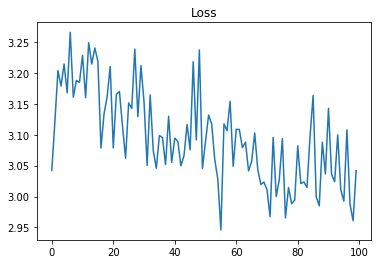

In [20]:
# plot loss curve
show_training_info(optimer)

Predicted training data: <START> a bathroom with a sink and a sink <END>


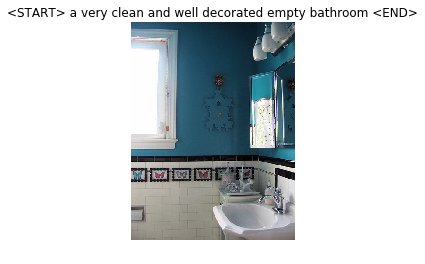

Predicted training data: <START> a living room with a couch and a <UNK> <END>


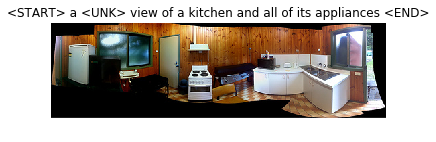

Predicted training data: <START> a street sign on a street with a <UNK> <UNK> on it <END>


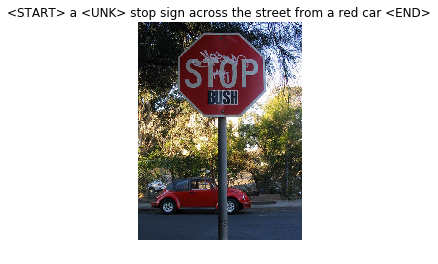

Predicted validation data: <START> a large <UNK> plane flying in the sky <END>


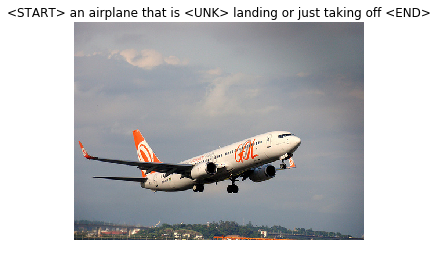

Predicted validation data: <START> a bathroom with a sink and a sink <END>


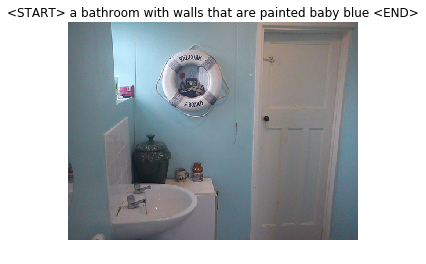

Predicted validation data: <START> a bathroom with a sink and a sink <END>


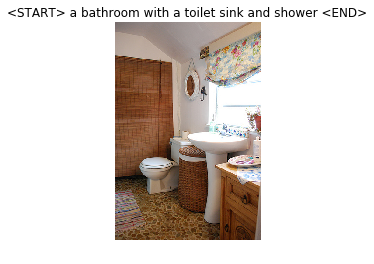

Predicted validation data: <START> a kitchen with a stove and a stove <END>


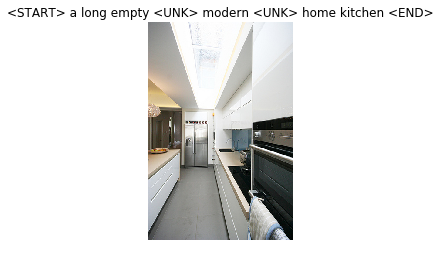

Predicted validation data: <START> a man is sitting on a couch with a laptop <END>


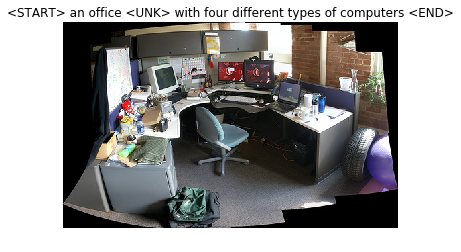

In [25]:
# load model
model = RNNCaption.load('./saves/RNNCaption/model.pkl')

# test model
test_model(model, dataloader, [0, 1, 4], [11, 12, 13, 14, 15])